# Assignment 1
**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Sexism Detection, Multi-class Classification, RNNs, Transformers, Huggingface



# Contact
For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

- Federico Ruggeri -> federico.ruggeri6@unibo.it
- Eleonora Mancini -> e.mancini@unibo.it

Professor:
- Paolo Torroni -> p.torroni@unibo.it

# Introduction
You are asked to address the [EXIST 2023 Task 1](https://clef2023.clef-initiative.eu/index.php?page=Pages/labs.html#EXIST) on sexism detection.

## Problem Definition
The systems have to decide whether or not a given tweet contains or describes sexist expressions or behaviors (i.e., it is sexist itself, describes a sexist situation or criticizes a sexist behavior).

### Examples:

**Text**: *Can’t go a day without women womening*

**Label**: Sexist

**Text**: *''Society's set norms! Happy men's day though!#weareequal''*

**Label**: Not sexist

#[Task 1 - 1.0 points] Corpus

We have preparared a small version of EXIST dataset in our dedicated [Github repository](https://github.com/lt-nlp-lab-unibo/nlp-course-material/tree/main/2024-2025/Assignment%201/data).

Check the `A1/data` folder. It contains 3 `.json` files representing `training`, `validation` and `test` sets.

The three sets are slightly unbalanced, with a bias toward the `Non-sexist` class.



### Dataset Description
- The dataset contains tweets in both English and Spanish.
- There are labels for multiple tasks, but we are focusing on **Task 1**.
- For Task 1, soft labels are assigned by six annotators.
- The labels for Task 1 represent whether the tweet is sexist ("YES") or not ("NO").







### Example


    "203260": {
        "id_EXIST": "203260",
        "lang": "en",
        "tweet": "ik when mandy says “you look like a whore” i look cute as FUCK",
        "number_annotators": 6,
        "annotators": ["Annotator_473", "Annotator_474", "Annotator_475", "Annotator_476", "Annotator_477", "Annotator_27"],
        "gender_annotators": ["F", "F", "M", "M", "M", "F"],
        "age_annotators": ["18-22", "23-45", "18-22", "23-45", "46+", "46+"],
        "labels_task1": ["YES", "YES", "YES", "NO", "YES", "YES"],
        "labels_task2": ["DIRECT", "DIRECT", "REPORTED", "-", "JUDGEMENTAL", "REPORTED"],
        "labels_task3": [
          ["STEREOTYPING-DOMINANCE"],
          ["OBJECTIFICATION"],
          ["SEXUAL-VIOLENCE"],
          ["-"],
          ["STEREOTYPING-DOMINANCE", "OBJECTIFICATION"],
          ["OBJECTIFICATION"]
        ],
        "split": "TRAIN_EN"
      }
    }

In [1]:
#0. IMPORTS
# file management
import urllib
from pathlib import Path

#zip file
import zipfile

# dataframe management
import pandas as pd

# data manipulation
import numpy as np

# for readability
from typing import Iterable

# viz
from tqdm import tqdm
'''
#Commented because I'm not using jupyter
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})
'''

"\n#Commented because I'm not using jupyter\nfrom notebook.services.config import ConfigManager\ncm = ConfigManager()\ncm.update('livereveal', {\n        'width': 1024,\n        'height': 768,\n        'scroll': True,\n})\n"

### Instructions
1. **Download** the `A1/data` folder.
2. **Load** the three JSON files and encode them as pandas dataframes.
3. **Generate hard labels** for Task 1 using majority voting and store them in a new dataframe column called `hard_label_task1`. Items without a clear majority will be removed from the dataset.
4. **Filter the DataFrame** to keep only rows where the `lang` column is `'en'`.
5. **Remove unwanted columns**: Keep only `id_EXIST`, `lang`, `tweet`, and `hard_label_task1`.
6. **Encode the `hard_label_task1` column**: Use 1 to represent "YES" and 0 to represent "NO".

### 1. Download the folder

In [2]:
class DownloadProgressBar(tqdm):
    """
    A class to represent a download progress bar, extending the tqdm class.
    """
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_url(download_path: Path, url: str):
    """
    Downloads a file from the given URL to the specified download path, displaying a progress bar.
    """
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=download_path, reporthook=t.update_to)

In [3]:
def download_dataset(download_path: Path, url: str):
    """
    Downloads a dataset from a given URL to a specified download path.
    """
    print("Downloading dataset...")
    download_url(url=url, download_path=download_path)
    print("Download complete!")


def extract_dataset(download_path: Path, extract_path: Path):
    """
    Extracts a dataset from a ZIP file.

    This function checks if the specified download path points to a ZIP file.
    If it does, the function extracts the contents of the ZIP file to the specified
    extraction path. If the file is not a ZIP file, an error message is printed.
    """
    print("Extracting dataset... (it may take a while...)")
    # Check if the file is a ZIP file
    if zipfile.is_zipfile(download_path):
        with zipfile.ZipFile(download_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print("Extraction completed!")
    else:
        print("Error: The downloaded file is not a ZIP file.")

In [4]:
# Define paths and URL
url = "https://github.com/nlp-unibo/nlp-course-material/archive/refs/heads/main.zip"
dataset_name = "Exist"
dataset_folder = Path.cwd().joinpath("Datasets")
dataset_folder.mkdir(exist_ok=True)  # Create folder if it doesn't exist
download_path = dataset_folder.joinpath(f"{dataset_name}.zip")

# Download and extract
download_dataset(download_path, url)
extract_dataset(download_path, dataset_folder)


main.zip: 4.58MB [00:02, 1.57MB/s]

Download complete!
Extracting dataset... (it may take a while...)
Extraction completed!


### 2. Load the three JSON files and encode them as pandas dataframes.

In [5]:
import pandas as pd
from pathlib import Path

# Define the path to the data folder and load JSON files as DataFrames
data_folder = dataset_folder.joinpath("nlp-course-material-main", "2024-2025", "Assignment 1", "data")

# Load each JSON file as a DataFrame
training_file = data_folder.joinpath("training.json")
test_file = data_folder.joinpath("test.json")
validation_file = data_folder.joinpath("validation.json")
"""
def load_json_file(file_path: Path) -> pd.DataFrame:
    Loads a JSON file as a DataFrame.
    
    with open(file_path, "r") as file:
        df = pd.read_json(file)
        print(f"{file_path.name} loaded successfully as a DataFrame!")
        print(f"{file_path.name} DataFrame shape: {df.shape}")
    return df
"""
def load_json_file(file_path: Path) -> pd.DataFrame:
    """
    Loads a JSON file as a DataFrame.
    """
    with open(file_path, "r", encoding="utf-8") as file:
        df = pd.read_json(file)
        print(f"{file_path.name} loaded successfully as a DataFrame!")
        print(f"{file_path.name} DataFrame shape: {df.shape}")
    return df



training_df = load_json_file(training_file)
test_df = load_json_file(test_file)
validation_df = load_json_file(validation_file)


training.json loaded successfully as a DataFrame!
training.json DataFrame shape: (11, 6920)
test.json loaded successfully as a DataFrame!
test.json DataFrame shape: (11, 312)
validation.json loaded successfully as a DataFrame!
validation.json DataFrame shape: (11, 726)


In [6]:
training_df.head()

,100001,100002,100003,100004,100005,100006,100007,100008,100009,100010,...,203251,203252,203253,203254,203255,203256,203257,203258,203259,203260
id_EXIST,100001,100002,100003,100004,100005,100006,100007,100008,100009,100010,...,203251,203252,203253,203254,203255,203256,203257,203258,203259,203260
lang,es,es,es,es,es,es,es,es,es,es,...,en,en,en,en,en,en,en,en,en,en
tweet,"@TheChiflis Ignora al otro, es un capullo.El p...",@ultimonomada_ Si comicsgate se parece en algo...,"@Steven2897 Lee sobre Gamergate, y como eso ha...",@Lunariita7 Un retraso social bastante lamenta...,@novadragon21 @icep4ck @TvDannyZ Entonces como...,@yonkykong Aaah sí. Andrew Dobson. El que se d...,@glutamatom @JoaquinAdolfoC Estaba del lado de...,@BestKabest Esta gringa sigue llorando por el ...,.¿Conoces la #DECORACION #estilo #GAMER para #...,CES 2022 ASUS ROG Rise of Gamers Evento de lan...,...,"""you look like a whore"" I'm literally wearing ...",“You look like a whore” if you think I’m cute ...,Who fucking lied to you? You look like a whore...,@ShefVaidya Ma'am if I say that you look like ...,I forgot I have a m*d that changes the drachen...,idk why y’all bitches think having half your a...,This has been a part of an experiment with @Wo...,"""Take me already"" ""Not yet. You gotta be ready...",@clintneedcoffee why do you look like a whore?...,ik when mandy says “you look like a whore” i l...
number_annotators,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
annotators,"[Annotator_1, Annotator_2, Annotator_3, Annota...","[Annotator_7, Annotator_8, Annotator_9, Annota...","[Annotator_7, Annotator_8, Annotator_9, Annota...","[Annotator_13, Annotator_14, Annotator_15, Ann...","[Annotator_19, Annotator_20, Annotator_21, Ann...","[Annotator_25, Annotator_26, Annotator_27, Ann...","[Annotator_25, Annotator_26, Annotator_27, Ann...","[Annotator_25, Annotator_26, Annotator_27, Ann...","[Annotator_31, Annotator_32, Annotator_33, Ann...","[Annotator_37, Annotator_38, Annotator_39, Ann...",...,"[Annotator_473, Annotator_474, Annotator_475, ...","[Annotator_617, Annotator_618, Annotator_619, ...","[Annotator_617, Annotator_618, Annotator_619, ...","[Annotator_668, Annotator_669, Annotator_670, ...","[Annotator_674, Annotator_675, Annotator_676, ...","[Annotator_478, Annotator_479, Annotator_480, ...","[Annotator_668, Annotator_669, Annotator_670, ...","[Annotator_467, Annotator_468, Annotator_469, ...","[Annotator_674, Annotator_675, Annotator_676, ...","[Annotator_473, Annotator_474, Annotator_475, ..."


In [7]:
test_df.head()

,400178,400179,400180,400181,400182,400183,400184,400185,400186,400187,...,400480,400481,400482,400483,400484,400485,400486,400487,400488,400489
id_EXIST,400178,400179,400180,400181,400182,400183,400184,400185,400186,400187,...,400480,400481,400482,400483,400484,400485,400486,400487,400488,400489
lang,en,en,en,en,en,en,en,en,en,en,...,en,en,en,en,en,en,en,en,en,en
tweet,1st day at the pool on a beautiful Sunday in N...,“I like your outfit too except when i dress up...,"@KNasFanFic 🥺💖 same, though!!! the angst just ...",@themaxburns @GOP Fuck that cunt. Tried to vot...,@ultshunnie u gotta say some shit like “i’ll f...,"@FernsLewds “Mmm, fuck that cunt is hungry for...",Suika gets gangbanged to death https://t.co/vn...,"“I mean I do, but… wouldn’t it be fun to get g...",@Fox_x_Gods Maybe something involving her gett...,@LogicalFallac18 @LBC Sex* as in 'gender' hara...,...,i hate liars😂. specifically those who lie bc t...,"Uh, they're allowed to? calling this out makes...",This genration are no more then selfish cunts....,@JetCelestial @polgara28951124 @CharlotteEmmaU...,@TheRealLyna Bitch your boyfriend Anthony flim...,@YesReallyAngel “Don’t wear a black bra with a...,""" get changed , you look like a prostitute . ""...",made this top and my mom gave me the “you look...,@DawnAnd91320913 I haven't seen anything that ...,@ElDukemane You look like a whore in ur new pi...
number_annotators,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
annotators,"[Annotator_764, Annotator_765, Annotator_766, ...","[Annotator_805, Annotator_426, Annotator_806, ...","[Annotator_795, Annotator_796, Annotator_797, ...","[Annotator_795, Annotator_796, Annotator_797, ...","[Annotator_770, Annotator_771, Annotator_772, ...","[Annotator_776, Annotator_777, Annotator_195, ...","[Annotator_780, Annotator_781, Annotator_782, ...","[Annotator_785, Annotator_786, Annotator_787, ...","[Annotator_770, Annotator_771, Annotator_772, ...","[Annotator_791, Annotator_122, Annotator_396, ...",...,"[Annotator_776, Annotator_777, Annotator_195, ...","[Annotator_805, Annotator_426, Annotator_806, ...","[Annotator_776, Annotator_777, Annotator_195, ...","[Annotator_801, Annotator_182, Annotator_802, ...","[Annotator_801, Annotator_182, Annotator_802, ...","[Annotator_801, Annotator_182, Annotator_802, ...","[Annotator_801, Annotator_182, Annotator_802, ...","[Annotator_795, Annotator_796, Annotator_797, ...","[Annotator_776, Annotator_777, Annotator_195, ...","[Annotator_776, Annotator_777, Annotator_195, ..."


In [8]:
validation_df.head()

,300001,300002,300003,300004,300005,300006,300007,300008,300009,300010,...,400168,400169,400170,400171,400172,400173,400174,400175,400176,400177
id_EXIST,300001,300002,300003,300004,300005,300006,300007,300008,300009,300010,...,400168,400169,400170,400171,400172,400173,400174,400175,400176,400177
lang,es,es,es,es,es,es,es,es,es,es,...,en,en,en,en,en,en,en,en,en,en
tweet,@Fichinescu La comunidad gamer es un antro de ...,@anacaotica88 @MordorLivin No me acuerdo de lo...,@cosmicJunkBot lo digo cada pocos dias y lo re...,Also mientras les decia eso la señalaba y deci...,"And all people killed, attacked, harassed by ...",On this #WorldPressFreedomDay I’m thinking of ...,@DavidGR18 @pppbernat @abc_es @agarzon @IreneM...,@DavidArranzVox @AnabelAlonso_of Uyyy a q huel...,Con 25 Leones🦁 y 500 más en las gradas🗣!!#EkoF...,@kokreto84 @Play87834898 @venusoncrack Me gust...,...,"I'm debating doing a ""feminization"" clip serie...",I'm looking for a girl I spoke to the day befo...,@parker__farquer Three for a girl.You're going...,Foreigner - Waiting for a Girl Like You [Lyric...,@leesu44 @elishabroadway @markbann57 @SeaeyesT...,Amazing that the GOP is trying to take away ou...,It is is impossible for a man to become a woma...,If Gaga decided to sing 18 versions of Free Wo...,This is your reminder that you can be child-fr...,"just completed my last final, i’m officially a..."
number_annotators,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
annotators,"[Annotator_726, Annotator_727, Annotator_357, ...","[Annotator_731, Annotator_732, Annotator_315, ...","[Annotator_735, Annotator_736, Annotator_345, ...","[Annotator_259, Annotator_739, Annotator_291, ...","[Annotator_731, Annotator_732, Annotator_315, ...","[Annotator_735, Annotator_736, Annotator_345, ...","[Annotator_731, Annotator_732, Annotator_315, ...","[Annotator_742, Annotator_743, Annotator_195, ...","[Annotator_742, Annotator_743, Annotator_195, ...","[Annotator_744, Annotator_745, Annotator_746, ...",...,"[Annotator_805, Annotator_426, Annotator_806, ...","[Annotator_780, Annotator_781, Annotator_782, ...","[Annotator_785, Annotator_786, Annotator_787, ...","[Annotator_764, Annotator_765, Annotator_766, ...","[Annotator_780, Annotator_781, Annotator_782, ...","[Annotator_805, Annotator_426, Annotator_806, ...","[Annotator_770, Annotator_771, Annotator_772, ...","[Annotator_764, Annotator_765, Annotator_766, ...","[Annotator_795, Annotator_796, Annotator_797, ...","[Annotator_770, Annotator_771, Annotator_772, ..."


In [9]:
training_df = training_df.transpose().set_index("id_EXIST")
test_df = test_df.transpose().set_index("id_EXIST")
validation_df = validation_df.transpose().set_index("id_EXIST")

In [10]:
training_df.head()

,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split
id_EXIST,,,,,,,,,,
100001,es,"@TheChiflis Ignora al otro, es un capullo.El p...",6,"[Annotator_1, Annotator_2, Annotator_3, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, YES, NO, YES, YES, YES]","[REPORTED, JUDGEMENTAL, -, REPORTED, JUDGEMENT...","[[OBJECTIFICATION], [OBJECTIFICATION, SEXUAL-V...",TRAIN_ES
100002,es,@ultimonomada_ Si comicsgate se parece en algo...,6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, YES, NO]","[-, -, -, -, DIRECT, -]","[[-], [-], [-], [-], [OBJECTIFICATION], [-]]",TRAIN_ES
100003,es,"@Steven2897 Lee sobre Gamergate, y como eso ha...",6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",TRAIN_ES
100004,es,@Lunariita7 Un retraso social bastante lamenta...,6,"[Annotator_13, Annotator_14, Annotator_15, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, YES, NO, YES, YES]","[-, -, DIRECT, -, REPORTED, REPORTED]","[[-], [-], [IDEOLOGICAL-INEQUALITY], [-], [IDE...",TRAIN_ES
100005,es,@novadragon21 @icep4ck @TvDannyZ Entonces como...,6,"[Annotator_19, Annotator_20, Annotator_21, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, NO, YES, NO, YES, YES]","[REPORTED, -, JUDGEMENTAL, -, JUDGEMENTAL, DIR...","[[STEREOTYPING-DOMINANCE, OBJECTIFICATION], [-...",TRAIN_ES


In [11]:
test_df.head()

,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split
id_EXIST,,,,,,,,,,
400178,en,1st day at the pool on a beautiful Sunday in N...,6,"[Annotator_764, Annotator_765, Annotator_766, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",DEV_EN
400179,en,“I like your outfit too except when i dress up...,6,"[Annotator_805, Annotator_426, Annotator_806, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[YES, YES, YES, YES, YES, NO]","[JUDGEMENTAL, DIRECT, REPORTED, DIRECT, REPORT...","[[OBJECTIFICATION], [OBJECTIFICATION, MISOGYNY...",DEV_EN
400180,en,"@KNasFanFic 🥺💖 same, though!!! the angst just ...",6,"[Annotator_795, Annotator_796, Annotator_797, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",DEV_EN
400181,en,@themaxburns @GOP Fuck that cunt. Tried to vot...,6,"[Annotator_795, Annotator_796, Annotator_797, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, YES, YES, YES, YES, YES]","[-, DIRECT, JUDGEMENTAL, DIRECT, DIRECT, DIRECT]","[[-], [IDEOLOGICAL-INEQUALITY, MISOGYNY-NON-SE...",DEV_EN
400182,en,@ultshunnie u gotta say some shit like “i’ll f...,6,"[Annotator_770, Annotator_771, Annotator_772, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[YES, YES, YES, YES, YES, YES]","[DIRECT, REPORTED, DIRECT, DIRECT, JUDGEMENTAL...","[[OBJECTIFICATION, SEXUAL-VIOLENCE], [SEXUAL-V...",DEV_EN


In [12]:
validation_df.head()

,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split
id_EXIST,,,,,,,,,,
300001,es,@Fichinescu La comunidad gamer es un antro de ...,6,"[Annotator_726, Annotator_727, Annotator_357, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, YES, YES, NO, YES, NO]","[-, JUDGEMENTAL, JUDGEMENTAL, -, REPORTED, -]","[[-], [MISOGYNY-NON-SEXUAL-VIOLENCE], [MISOGYN...",DEV_ES
300002,es,@anacaotica88 @MordorLivin No me acuerdo de lo...,6,"[Annotator_731, Annotator_732, Annotator_315, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[YES, YES, NO, YES, YES, YES]","[JUDGEMENTAL, REPORTED, -, JUDGEMENTAL, JUDGEM...","[[IDEOLOGICAL-INEQUALITY, STEREOTYPING-DOMINAN...",DEV_ES
300003,es,@cosmicJunkBot lo digo cada pocos dias y lo re...,6,"[Annotator_735, Annotator_736, Annotator_345, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",DEV_ES
300004,es,Also mientras les decia eso la señalaba y deci...,6,"[Annotator_259, Annotator_739, Annotator_291, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, YES, YES, YES, YES, YES]","[-, REPORTED, REPORTED, REPORTED, JUDGEMENTAL,...","[[-], [SEXUAL-VIOLENCE], [SEXUAL-VIOLENCE], [S...",DEV_ES
300005,es,"And all people killed, attacked, harassed by ...",6,"[Annotator_731, Annotator_732, Annotator_315, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, YES, NO, NO, NO, NO]","[-, DIRECT, -, -, -, -]","[[-], [STEREOTYPING-DOMINANCE], [-], [-], [-],...",DEV_ES


### 3. Generate hard labels for Task 1 using majority voting and store them in a new dataframe column called hard_label_task1. Items without a clear majority will be removed from the dataset.

In [13]:
def majority_vote(labels):
    """
    Determines the majority vote from a list of labels.
    """
    yes_count = labels.count('YES')
    no_count = labels.count('NO')
    if yes_count > no_count:
        return 'YES'
    elif no_count > yes_count:
        return 'NO'
    else:
        return None

# Apply the majority_vote function to the 'labels_task1' column
for df in [training_df, test_df, validation_df]:
    df['hard_label_task1'] = df['labels_task1'].apply(majority_vote)

# Display the result for the training DataFrame
training_df.head()

,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split,hard_label_task1
id_EXIST,,,,,,,,,,,
100001,es,"@TheChiflis Ignora al otro, es un capullo.El p...",6,"[Annotator_1, Annotator_2, Annotator_3, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, YES, NO, YES, YES, YES]","[REPORTED, JUDGEMENTAL, -, REPORTED, JUDGEMENT...","[[OBJECTIFICATION], [OBJECTIFICATION, SEXUAL-V...",TRAIN_ES,YES
100002,es,@ultimonomada_ Si comicsgate se parece en algo...,6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, YES, NO]","[-, -, -, -, DIRECT, -]","[[-], [-], [-], [-], [OBJECTIFICATION], [-]]",TRAIN_ES,NO
100003,es,"@Steven2897 Lee sobre Gamergate, y como eso ha...",6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",TRAIN_ES,NO
100004,es,@Lunariita7 Un retraso social bastante lamenta...,6,"[Annotator_13, Annotator_14, Annotator_15, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, YES, NO, YES, YES]","[-, -, DIRECT, -, REPORTED, REPORTED]","[[-], [-], [IDEOLOGICAL-INEQUALITY], [-], [IDE...",TRAIN_ES,None
100005,es,@novadragon21 @icep4ck @TvDannyZ Entonces como...,6,"[Annotator_19, Annotator_20, Annotator_21, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, NO, YES, NO, YES, YES]","[REPORTED, -, JUDGEMENTAL, -, JUDGEMENTAL, DIR...","[[STEREOTYPING-DOMINANCE, OBJECTIFICATION], [-...",TRAIN_ES,YES


In [14]:
# Drop rows with missing values (for no majority vote case)
print("### Before dropping missing values ###")
print(f"Training DataFrame shape before dropping missing values: {training_df.shape}")
print(f"Test DataFrame shape before dropping missing values: {test_df.shape}")
print(f"Validation DataFrame shape before dropping missing values: {validation_df.shape}")

training_df = training_df.dropna()
test_df = test_df.dropna()
validation_df = validation_df.dropna()

print("### After dropping missing values ###")
print(f"Training DataFrame shape after dropping missing values: {training_df.shape}")
print(f"Test DataFrame shape after dropping missing values: {test_df.shape}")
print(f"Validation DataFrame shape after dropping missing values: {validation_df.shape}")

### Before dropping missing values ###
Training DataFrame shape before dropping missing values: (6920, 11)
Test DataFrame shape before dropping missing values: (312, 11)
Validation DataFrame shape before dropping missing values: (726, 11)
### After dropping missing values ###
Training DataFrame shape after dropping missing values: (6064, 11)
Test DataFrame shape after dropping missing values: (286, 11)
Validation DataFrame shape after dropping missing values: (648, 11)


### 4. Keep only 'en' language

In [15]:
print("### Before filtering by language ###")
print(f"Training DataFrame shape before filtering by language: {training_df.shape}")
print(f"Test DataFrame shape before filtering by language: {test_df.shape}")
print(f"Validation DataFrame shape before filtering by language: {validation_df.shape}")

training_df = training_df[training_df['lang'] == 'en']
test_df = test_df[test_df['lang'] == 'en']
validation_df = validation_df[validation_df['lang'] == 'en']

print("### After filtering by language ###")
print(f"Training DataFrame shape after filtering by language: {training_df.shape}")
print(f"Test DataFrame shape after filtering by language: {test_df.shape}")
print(f"Validation DataFrame shape after filtering by language: {validation_df.shape}")

### Before filtering by language ###
Training DataFrame shape before filtering by language: (6064, 11)
Test DataFrame shape before filtering by language: (286, 11)
Validation DataFrame shape before filtering by language: (648, 11)
### After filtering by language ###
Training DataFrame shape after filtering by language: (2870, 11)
Test DataFrame shape after filtering by language: (286, 11)
Validation DataFrame shape after filtering by language: (158, 11)


### 5. Keep only relevant columns

In [16]:
training_df = training_df.drop(columns=['number_annotators',	'annotators',	'gender_annotators',	'age_annotators',	'labels_task1',	'labels_task2',	'labels_task3',	'split'])
test_df = test_df.drop(columns=['number_annotators',	'annotators',	'gender_annotators',	'age_annotators',	'labels_task1',	'labels_task2',	'labels_task3',	'split'])
validation_df = validation_df.drop(columns=['number_annotators',	'annotators',	'gender_annotators',	'age_annotators',	'labels_task1',	'labels_task2',	'labels_task3',	'split'])

training_df.head()

,lang,tweet,hard_label_task1
id_EXIST,,,
200002,en,Writing a uni essay in my local pub with a cof...,YES
200003,en,@UniversalORL it is 2021 not 1921. I dont appr...,YES
200006,en,According to a customer I have plenty of time ...,YES
200007,en,"So only 'blokes' drink beer? Sorry, but if you...",YES
200008,en,New to the shelves this week - looking forward...,NO


### 6. YES = 1, NO = 0

In [17]:
for df in [training_df, test_df, validation_df]:
    df['hard_label_task1'] = df['hard_label_task1'].map({'YES': 1, 'NO': 0})

training_df.head()

,lang,tweet,hard_label_task1
id_EXIST,,,
200002,en,Writing a uni essay in my local pub with a cof...,1
200003,en,@UniversalORL it is 2021 not 1921. I dont appr...,1
200006,en,According to a customer I have plenty of time ...,1
200007,en,"So only 'blokes' drink beer? Sorry, but if you...",1
200008,en,New to the shelves this week - looking forward...,0


# [Task2 - 0.5 points] Data Cleaning
In the context of tweets, we have noisy and informal data that often includes unnecessary elements like emojis, hashtags, mentions, and URLs. These elements may interfere with the text analysis.



### Instructions
- **Remove emojis** from the tweets.
- **Remove hashtags** (e.g., `#example`).
- **Remove mentions** such as `@user`.
- **Remove URLs** from the tweets.
- **Remove special characters and symbols**.
- **Remove specific quote characters** (e.g., curly quotes).
- **Perform lemmatization** to reduce words to their base form.

### 0. Adjust the stop symbols (this was not requested but I added it anyway because it was done in class)

In [18]:
import re
from functools import reduce
import nltk
from nltk.corpus import stopwords

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
GOOD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
try:
    STOPWORDS = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    STOPWORDS = set(stopwords.words('english'))

### 1. Remove emojis

In order to complete this task we need to import the regex. Of course this is taken from the internet because where the fuck was I able to get the fucking regex of the emojis, I don't know shit about this.

In [19]:
def lower(text: str) -> str:
    """
    Transforms given text to lower case.
    """
    return text.lower()

In [20]:
test_df.head()

,lang,tweet,hard_label_task1
id_EXIST,,,
400178,en,1st day at the pool on a beautiful Sunday in N...,0
400179,en,“I like your outfit too except when i dress up...,1
400180,en,"@KNasFanFic 🥺💖 same, though!!! the angst just ...",0
400181,en,@themaxburns @GOP Fuck that cunt. Tried to vot...,1
400182,en,@ultshunnie u gotta say some shit like “i’ll f...,1


In [21]:
import re

def remove_emojis(text):
    # By encoding in 'ascii', emojis are removed
    return text.encode('ascii', 'ignore').decode('ascii')

### 2. Remove hashtags

In [22]:
def remove_hashtags(text):
    # Regex pattern to match hashtags
    hashtag_pattern = r'#\w+'  # Matches words starting with # followed by any alphanumeric characters or underscores

    # Substitute hashtags with an empty string
    return re.sub(hashtag_pattern, '', text)

### 3. Remove mentions

In [23]:
def remove_mentions(text):
    # Regex pattern to match Twitter mentions (e.g., @username)
    mention_pattern = r'@\w+'  # Matches @ followed by any alphanumeric characters or underscores

    # Substitute mentions with an empty string
    return re.sub(mention_pattern, '', text)

### 4. Remove urls

In [24]:
def remove_urls(text):
    # Regex pattern to match URLs (http://, https://, ftp://, etc.)
    url_pattern = r'http[s]?://\S+'  # Matches URLs starting with http:// or https:// and followed by non-whitespace characters

    # Substitute URLs with an empty string
    return re.sub(url_pattern, '', text)

### 5. Remove special characters

In [25]:
def replace_special_characters(text: str) -> str:
    """
    Replaces special characters, such as paranthesis, with spacing character
    """
    return REPLACE_BY_SPACE_RE.sub(' ', text)

### 6. Remove quotations characters

In [26]:
def remove_quotations(text):
    # Regex pattern to match single and double quotes
    quote_pattern = r"[\"'‘’“”]"  # Matches either single quotes (') or double quotes (")

    # Substitute quotation marks with an empty string
    return re.sub(quote_pattern, '', text)

Before going ahead with lemmatization I want to perform this to the whole column containing the tweets

In [27]:
# typing
from typing import List, Callable, Dict
from collections import OrderedDict

PREPROCESSING_PIPELINE = [
                          lower,
                          remove_emojis,
                          remove_hashtags,
                          remove_mentions,
                          remove_urls,
                          replace_special_characters,
                          remove_quotations
                          ]

def text_prepare(text: str,
                 filter_methods: List[Callable[[str], str]] = None) -> str:
    """
    Applies a list of pre-processing functions in sequence (reduce).
    Note that the order is important here!
    """
    filter_methods = filter_methods if filter_methods is not None else PREPROCESSING_PIPELINE
    return reduce(lambda txt, f: f(txt), filter_methods, text)

In [28]:
print('Pre-processing text...')

print()
print(f'[Debug train] Before:\n{training_df.tweet.values[50]}')
print(f'[Debug test] Before:\n{test_df.tweet.values[50]}')
print(f'[Debug validation] Before:\n{validation_df.tweet.values[50]}')
print()

# Replace each sentence with its pre-processed version
training_df['tweet'] = training_df['tweet'].apply(lambda txt: text_prepare(txt))
test_df['tweet'] = test_df['tweet'].apply(lambda txt: text_prepare(txt))
validation_df['tweet'] = validation_df['tweet'].apply(lambda txt: text_prepare(txt))


print(f'[Debug train] After:\n{training_df.tweet.values[50]}')
print(f'[Debug test] After:\n{test_df.tweet.values[50]}')
print(f'[Debug validation] After:\n{validation_df.tweet.values[50]}')
print()

print("Pre-processing completed!")

Pre-processing text...

[Debug train] Before:
@LibertyAnders I get it.. kind of. 80% of women are going after about 20% of men and ignoring the rest according to statistics of 3 dating apps. so that’s a pain point for some men, but Is hating women really a main component to being an incel? And what’s the difference between MGTOW and Incel?
[Debug test] Before:
@HTFCirno2000 I have an old receipt printer thing but I have no idea how to use it. I would like to fuck with it like you did. https://t.co/UpXFySfBwB
[Debug validation] Before:
@motahedoon Alrubaye bint moawad Good luck 💜💜💜💜🤍🤍#motahedoon_challeng

[Debug train] After:
 i get it.. kind of. 80% of women are going after about 20% of men and ignoring the rest according to statistics of 3 dating apps. so thats a pain point for some men  but is hating women really a main component to being an incel? and whats the difference between mgtow and incel?
[Debug test] After:
 i have an old receipt printer thing but i have no idea how to use 

### 7. Perform lemmatization

In [29]:
#creating lemmatizer object
import nltk
from nltk.corpus import wordnet

tokenizer = nltk.tokenize.WhitespaceTokenizer()

nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

lemmatizer = nltk.WordNetLemmatizer()

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\WIN11\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\WIN11\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\WIN11\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\WIN11\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [30]:
def get_wordnet_key(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return 'n'

def lem_text(text: str):
    tokens = tokenizer.tokenize(text)
    tagged = nltk.pos_tag(tokens)
    words = [lemmatizer.lemmatize(word, get_wordnet_key(tag)) for word, tag in tagged]
    return " ".join(words)

training_df['tweet'] = [lem_text(text) for text in tqdm(training_df['tweet'], leave=True, position=0)]
test_df['tweet'] = [lem_text(text) for text in tqdm(test_df['tweet'], leave=True, position=0)]
validation_df['tweet'] = [lem_text(text) for text in tqdm(validation_df['tweet'], leave=True, position=0)]


100%|██████████| 158/158 [00:00<00:00, 2368.35it/s]


In [31]:
training_df.head()

,lang,tweet,hard_label_task1
id_EXIST,,,
200002,en,write a uni essay in my local pub with a coffe...,1
200003,en,it be 2021 not 1921. i dont appreciate that on...,1
200006,en,accord to a customer i have plenty of time to ...,1
200007,en,so only blokes drink beer? sorry but if you ar...,1
200008,en,new to the shelf this week - look forward to r...,0


In [32]:
print(f'[Debug] After:\n{training_df.tweet.values[50]}')
print()

[Debug] After:
i get it.. kind of. 80% of woman be go after about 20% of men and ignore the rest accord to statistic of 3 date apps. so thats a pain point for some men but be hat woman really a main component to be an incel? and whats the difference between mgtow and incel?



# [Task 3 - 0.5 points] Text Encoding
To train a neural sexism classifier, you first need to encode text into numerical format.




### Instructions

* Embed words using **GloVe embeddings**.
* You are **free** to pick any embedding dimension.





### Note : What about OOV tokens?
   * All the tokens in the **training** set that are not in GloVe **must** be added to the vocabulary.
   * For the remaining tokens (i.e., OOV in the validation and test sets), you have to assign them a **special token** (e.g., [UNK]) and a **static** embedding.
   * You are **free** to define the static embedding using any strategy (e.g., random, neighbourhood, etc...)



### More about OOV

For a given token:

* **If in train set**: add to vocabulary and assign an embedding (use GloVe if token in GloVe, custom embedding otherwise).
* **If in val/test set**: assign special token if not in vocabulary and assign custom embedding.

Your vocabulary **should**:

* Contain all tokens in train set; or
* Union of tokens in train set and in GloVe $\rightarrow$ we make use of existing knowledge!

In [33]:
import gensim
import gensim.downloader as gloader
import gzip

def load_embedding_model(model_type: str,
                         return_path: bool,
                         embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    """
    Loads a pre-trained word embedding model via gensim library.

    :param model_type: name of the word embedding model to load.
    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """
    download_path = ""
    if model_type.strip().lower() == 'glove-twitter':
        download_path = "glove-twitter-{}".format(embedding_dimension)

    elif model_type.strip().lower() == 'glove-wiki-gigaword':
        download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    else:
        raise AttributeError("Unsupported embedding model type! Available ones: glove-wiki-gigaword, glove-twitter")

    try:
        emb_model = gloader.load(download_path,return_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("glove-twitter: 25, 50, 100, 200")
        print("glove-wiki-gigaword: 50, 100, 200, 300")
        raise e

    return emb_model

import gzip

def from_txt_to_dictionary(glove_file_path):
    embeddings = {}

    with gzip.open(glove_file_path, 'rt', encoding='utf-8') as f:
        for line in f:
            # Split each line into word and its embedding
            values = line.split()
            word = values[0]
            vector = list(map(float, values[1:]))
            embeddings[word] = vector

    return embeddings

Now we need to define the functions to build the vocabulary

In [34]:
# Initialize vocabulary with GloVe and custom embeddings
def build_vocabulary(train_tokens, glove_embeddings, embedding_dim=50):
    vocabulary = {}
    for token in set(train_tokens):
        if token in glove_embeddings:
            vocabulary[token] = glove_embeddings[token]
        else:
            # Assign random vector for OOV tokens in the train set
            vocabulary[token] = np.random.uniform(-0.5, 0.5, embedding_dim)
    return vocabulary


Then the embeddings from the text and the OOV case

In [35]:
# Define the [UNK] embedding as the average of all embeddings
def define_unk_embedding(vocabulary):
    return np.mean(list(vocabulary.values()), axis=0)

# Convert tokens in text to embeddings
def text_to_embeddings(text, vocabulary, unk_embedding):
    embeddings = []
    for token in text.split():
        token = token.lower()
        if token in vocabulary:
            embeddings.append(vocabulary[token])
        else:
            embeddings.append(unk_embedding)  # Use [UNK] embedding for unknown tokens
    return np.array(embeddings)

In [36]:
embedding_dim = 200
glove_file_path=load_embedding_model('glove-twitter', return_path=True, embedding_dimension=embedding_dim)
glove_embeddings=from_txt_to_dictionary(glove_file_path)

In [37]:
# Step 2: Tokenize and build vocabulary using only training tokens
train_tokens = [word.lower() for tweet in training_df['tweet'] for word in tweet.split()]
vocabulary = build_vocabulary(train_tokens, glove_embeddings, embedding_dim)

# Step 3: Define [UNK] embedding
unk_embedding = define_unk_embedding(vocabulary)

# Step 4: Embed the 'tweet' column in each dataframe
def embed_tweets(df, vocabulary, unk_embedding):
    df['tweet_embedding'] = df['tweet'].apply(lambda tweet: text_to_embeddings(tweet, vocabulary, unk_embedding))
    return df

# Apply to each dataframe
training_df = embed_tweets(training_df, vocabulary, unk_embedding)
test_df = embed_tweets(test_df, vocabulary, unk_embedding)
validation_df = embed_tweets(validation_df, vocabulary, unk_embedding)

In [38]:
training_df.head()

,lang,tweet,hard_label_task1,tweet_embedding
id_EXIST,,,,
200002,en,write a uni essay in my local pub with a coffe...,1,"[[0.23606, 0.46571, 0.0091574, -0.022217, -0.4..."
200003,en,it be 2021 not 1921. i dont appreciate that on...,1,"[[-0.20397, 0.45338, -0.1684, 0.14302, -0.0948..."
200006,en,accord to a customer i have plenty of time to ...,1,"[[-0.078828, -0.13376, -0.50952, 0.46567, 0.04..."
200007,en,so only blokes drink beer? sorry but if you ar...,1,"[[0.12018, 0.038966, 0.027403, 0.16089, 0.1336..."
200008,en,new to the shelf this week - look forward to r...,0,"[[0.27554, 0.15505, -0.39506, 0.35, 0.018967, ..."


In [39]:
validation_df.head()

,lang,tweet,hard_label_task1,tweet_embedding
id_EXIST,,,,
400001,en,you should smile more love. just pretend youre...,0,"[[0.1964, 0.67153, 0.0062976, 0.25359, -0.4209..."
400002,en,she be right but the push be all in the opposi...,1,"[[-0.18295, 0.28614, 0.11604, 0.36726, 0.17055..."
400003,en,some man move my suitcase in the overhead lugg...,1,"[[0.00096193, -0.1576, -0.15985, 0.037884, 0.1..."
400004,en,lol gamergate the go to boogieman maybe if the...,0,"[[0.3043, -0.047127, 0.0067446, -0.070278, -0...."
400005,en,to me this have the same negativity a gamergat...,0,"[[0.61774, 0.21046, 0.52698, 0.20467, 0.257, -..."


In [40]:
test_df.head()

,lang,tweet,hard_label_task1,tweet_embedding
id_EXIST,,,,
400178,en,1st day at the pool on a beautiful sunday in n...,0,"[[0.21283810643880363, -0.1415987484103488, 0...."
400179,en,i like your outfit too except when i dress up ...,1,"[[0.056404, 0.49536, 0.18439, 0.054535, -0.517..."
400180,en,same though!!! the angst just come and goes. l...,0,"[[0.48162, -0.080498, 0.089994, 0.794, 0.15886..."
400181,en,fuck that cunt. try to vote her out multiple time,1,"[[-0.20878, 0.16733, -0.0078498, 0.11349, -0.6..."
400182,en,u gotta say some shit like ill fuck that cunt ...,1,"[[0.38137, 0.36436, 0.25135, 0.13976, 0.026781..."


# [Task 4 - 1.0 points] Model definition

You are now tasked to define your sexism classifier.




### Instructions

* **Baseline**: implement a Bidirectional LSTM with a Dense layer on top.
* You are **free** to experiment with hyper-parameters to define the baseline model.

* **Model 1**: add an additional LSTM layer to the Baseline model.

### Token to embedding mapping

You can follow two approaches for encoding tokens in your classifier.

### Work directly with embeddings

- Compute the embedding of each input token
- Feed the mini-batches of shape (batch_size, # tokens, embedding_dim) to your model

### Work with Embedding layer

- Encode input tokens to token ids
- Define a Embedding layer as the first layer of your model
- Compute the embedding matrix of all known tokens (i.e., tokens in your vocabulary)
- Initialize the Embedding layer with the computed embedding matrix
- You are **free** to set the Embedding layer trainable or not

In [41]:
import tensorflow as tf

In [42]:
vocab_size = len(vocabulary)
embedding_dimension = embedding_dim
embedding_matrix = embedding_matrix = np.array(list(vocabulary.values()))
embedding = tf.keras.layers.Embedding(input_dim=vocab_size,
                                      output_dim=embedding_dimension,
                                      weights=[embedding_matrix],
                                      mask_zero=True,                   # automatically masks padding tokens
                                      name='encoder_embedding')

### Padding

Pay attention to padding tokens!

Your model **should not** be penalized on those tokens.

#### How to?

There are two main ways.

However, their implementation depends on the neural library you are using.

- Embedding layer
- Custom loss to compute average cross-entropy on non-padding tokens only

**Note**: This is a **recommendation**, but we **do not penalize** for missing workarounds.

In [43]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Ensure that each tweet embedding is padded to a consistent length
sequence_length = 100  # Define based on your needs or average embedding length in data

# Apply padding directly on the tweet_embedding column
X_train = pad_sequences(training_df['tweet_embedding'].tolist(), maxlen=sequence_length, dtype='float32', padding='post', truncating='post')
X_val = pad_sequences(validation_df['tweet_embedding'].tolist(), maxlen=sequence_length, dtype='float32', padding='post', truncating='post')

# Convert labels to numpy arrays
y_train = training_df['hard_label_task1'].values
y_val = validation_df['hard_label_task1'].values


In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, TimeDistributed

'''
REMEMBER: YOU SHOULD WRAP THE DENSE LAYER WITH TIMEDISTRIBUTED BUT I'M NOT FIGURING OUT HOW TO FIX THE SHAPE PROBLEMS DHN
'''
def create_baseline_model(input_shape, lstm_units=128):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=lstm_units, return_sequences=False), input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification
    return model


In [45]:
'''
REMEMBER: YOU SHOULD WRAP THE DENSE LAYER WITH TIMEDISTRIBUTED BUT I'M NOT FIGURING OUT HOW TO FIX THE SHAPE PROBLEMS DHN
'''

def create_model_1(input_shape, lstm_units=128):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=lstm_units, return_sequences=True), input_shape=input_shape))  # First LSTM layer
    model.add(Bidirectional(LSTM(units=lstm_units, return_sequences=False)))  # Second LSTM layer
    model.add(Dense(1, activation='sigmoid'))
    return model


# [Task 5 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate the Baseline and Model 1.



### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Compute metrics on the validation set.
* Pick **at least** three seeds for robust estimation.
* Pick the **best** performing model according to the observed validation set performance.
* Evaluate your models using macro F1-score.

In [46]:
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import Callback, EarlyStopping
import numpy as np

# Custom Callback to compute F1-score
class F1ScoreCallback(Callback):
    def __init__(self, val_data):
        self.val_data = val_data

    def on_epoch_end(self, epoch, logs=None):
        val_x, val_y = self.val_data
        val_predictions = (self.model.predict(val_x) > 0.5).astype(int)  # Binarize predictions
        f1 = f1_score(val_y, val_predictions, average="macro")
        print(f"Epoch {epoch + 1}: Macro F1-Score = {f1:.4f}")
        logs['val_f1'] = f1  # Add F1 to logs for history tracking

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



In [47]:
input_shape = (sequence_length, X_train.shape[2])  # Shape of each input sample: (sequence_length, embedding_dim)

#### Training with random seed

In [48]:
import tensorflow as tf
import numpy as np
import random

def set_seeds(seed):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


In [49]:
from sklearn.metrics import classification_report

In [50]:
seeds = [42, 123, 789]  # Example seeds
baseline_f1_scores = []
model_1_f1_scores = []

for seed in seeds:
    print(f"Training with seed {seed}")
    set_seeds(seed)

    # Create and compile the baseline model
    baseline_model = create_baseline_model(input_shape=input_shape, lstm_units=128)
    baseline_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    f1_callback = F1ScoreCallback(val_data=(X_val, y_val))
    # Train the model
    baseline_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, callbacks=[f1_callback], verbose=0)

    # Evaluate on validation set
    val_predictions = (baseline_model.predict(X_val) > 0.5).astype(int)
    macro_f1 = f1_score(y_val, val_predictions, average='macro')
    baseline_f1_scores.append(macro_f1)
    print(f"Seed {seed} - Macro F1-Score: {macro_f1:.4f}")

    #print(classification_report(y_val, val_predictions, target_names=['Not Sexist', 'Sexist']))


Training with seed 42


C:\Users\WIN11\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Epoch 1: Macro F1-Score = 0.7350
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Epoch 2: Macro F1-Score = 0.7776
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epoch 3: Macro F1-Score = 0.7790
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Epoch 4: Macro F1-Score = 0.7864
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Epoch 5: Macro F1-Score = 0.8131
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Epoch 6: Macro F1-Score = 0.7684
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epoch 7: Macro F1-Score = 0.7911
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epoch 8: Macro F1-Score = 0.8003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Epoch 9: Macro F1-Score = 0.8253
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Epoch 10: Macro F1-Score = 0.8192
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Seed 42 - Macro F1-Score: 0.8192
Training with seed 123


C:\Users\WIN11\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Epoch 1: Macro F1-Score = 0.6960
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 2: Macro F1-Score = 0.7269
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 3: Macro F1-Score = 0.7667
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epoch 4: Macro F1-Score = 0.7881
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 5: Macro F1-Score = 0.7959
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epoch 6: Macro F1-Score = 0.7925
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epoch 7: Macro F1-Score = 0.8070
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epoch 8: Macro F1-Score = 0.7997
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epoch 9: Macro F1-Score = 0.8018
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Epoch 10: Macro F1-Score = 0.7716
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Seed 123 - Macro F1-Score: 0.7716
Training with seed 789


C:\Users\WIN11\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Epoch 1: Macro F1-Score = 0.7255
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Epoch 2: Macro F1-Score = 0.7431
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Epoch 3: Macro F1-Score = 0.7806
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epoch 4: Macro F1-Score = 0.7649
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 5: Macro F1-Score = 0.7985
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Epoch 6: Macro F1-Score = 0.7761
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 7: Macro F1-Score = 0.7896
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Epoch 8: Macro F1-Score = 0.7769
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epoch 9: Macro F1-Score = 0.7597
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Epoch 10: Macro F1-Score = 0.8058
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Seed 789 - Macro F1-Score: 0.8058


In [51]:
for seed in seeds:
    print(f"Training with seed {seed}")
    set_seeds(seed)

    # Create and compile the baseline model
    model_1 = create_model_1(input_shape=input_shape, lstm_units=128)
    model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    f1_callback = F1ScoreCallback(val_data=(X_val, y_val))
    # Train the model
    model_1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, callbacks = [f1_callback], verbose=0)

    # Evaluate on validation set
    val_predictions = (baseline_model.predict(X_val) > 0.5).astype(int)
    macro_f1 = f1_score(y_val, val_predictions, average='macro')
    model_1_f1_scores.append(macro_f1)
    print(f"Seed {seed} - Macro F1-Score: {macro_f1:.4f}")

    print(classification_report(y_val, val_predictions, target_names=['Not Sexist', 'Sexist']))

Training with seed 42


C:\Users\WIN11\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
Epoch 1: Macro F1-Score = 0.7372
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Epoch 2: Macro F1-Score = 0.7761
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Epoch 3: Macro F1-Score = 0.7911
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Epoch 4: Macro F1-Score = 0.7896
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Epoch 5: Macro F1-Score = 0.8180
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 6: Macro F1-Score = 0.8119
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Epoch 7: Macro F1-Score = 0.7756
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Epoch 8: Macro F1-Score = 0.7858
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Epoch 9: Macro F1-Score = 0.7776
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Epoch 10: Macro F1-Score = 0.7641
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Seed 42 - Macro F1-Score: 0.8058
              precision    recall  f1-score   support

  Not Sexist       0.79      0.92      0.85        90
      Sexist       0.87      0.68      0.76        68

    accuracy                           0.82       158


C:\Users\WIN11\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
Epoch 1: Macro F1-Score = 0.7245
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Epoch 2: Macro F1-Score = 0.6871
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Epoch 3: Macro F1-Score = 0.7129
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Epoch 4: Macro F1-Score = 0.7850
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Epoch 5: Macro F1-Score = 0.7649
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Epoch 6: Macro F1-Score = 0.7876
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Epoch 7: Macro F1-Score = 0.7489
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Epoch 8: Macro F1-Score = 0.7530
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Epoch 9: Macro F1-Score = 0.8152
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Epoch 10: Macro F1-Score = 0.8056
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Seed 123 - Macro F1-Score: 0.8058
              precision    recall  f1-score   support

  Not Sexist       0.79      0.92      0.85        90
      Sexist       0.87      0.68      0.76        68

    accuracy                           0.82       158

C:\Users\WIN11\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
Epoch 1: Macro F1-Score = 0.7431
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 2: Macro F1-Score = 0.8064
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Epoch 3: Macro F1-Score = 0.8179
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Epoch 4: Macro F1-Score = 0.8015
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Epoch 5: Macro F1-Score = 0.8556
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Epoch 6: Macro F1-Score = 0.7887
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 7: Macro F1-Score = 0.8264
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Epoch 8: Macro F1-Score = 0.8366
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Epoch 9: Macro F1-Score = 0.8388
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Epoch 10: Macro F1-Score = 0.7656
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Seed 789 - Macro F1-Score: 0.8058
              precision    recall  f1-score   support

  Not Sexist       0.79      0.92      0.85        90
      Sexist       0.87      0.68      0.76        68

    accuracy                           0.82       158

#### Pick the best performing model

In [52]:
f1_scores = baseline_f1_scores + model_1_f1_scores
print(f1_scores)

[0.8191989828353465, 0.7715986394557823, 0.805806314897224, 0.805806314897224, 0.805806314897224, 0.805806314897224]


In [53]:
best_seed = seeds[np.argmax(f1_scores)]
best_f1_baseline = max(baseline_f1_scores)
best_f1_model_1 = max(model_1_f1_scores)
best_f1 = max(best_f1_baseline, best_f1_model_1)
best_model = "Baseline" if best_f1 == best_f1_baseline else "Model 1"
print(f"Best Model: {best_model} with Best Seed: {best_seed} with Macro F1-Score: {best_f1:.4f}")

Best Model: Baseline with Best Seed: 42 with Macro F1-Score: 0.8192


#### Evaluate best performing model

In [54]:
set_seeds(best_seed)
if best_model == 'Baseline':
    best_model = create_baseline_model(input_shape=input_shape, lstm_units=128)
else:
    best_model = create_model_1(input_shape=input_shape, lstm_units=128)

best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Retrain the best model
best_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)


Epoch 1/10


C:\Users\WIN11\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6396 - loss: 0.6303 - val_accuracy: 0.7595 - val_loss: 0.5042
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7717 - loss: 0.4970 - val_accuracy: 0.7911 - val_loss: 0.4836
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8102 - loss: 0.4421 - val_accuracy: 0.7911 - val_loss: 0.4746
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8192 - loss: 0.4041 - val_accuracy: 0.7975 - val_loss: 0.4856
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8545 - loss: 0.3614 - val_accuracy: 0.8228 - val_loss: 0.4816
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8389 - loss: 0.3844 - val_accuracy: 0.7722 - val_loss: 0.5173
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8369 - loss: 0.3800 - val_accuracy: 0.8038 - val_loss: 0.4932
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8723 - loss: 0.3146 - val_accuracy: 0.8165 - val_loss: 0.

In [55]:
# Final Evaluation
final_val_predictions = (best_model.predict(X_val) > 0.5).astype(int)
final_macro_f1 = f1_score(y_val, final_val_predictions, average='macro')
print(f"Final Model (Seed {best_seed}) - Macro F1-Score: {final_macro_f1:.4f}")

best_cr = classification_report(y_val, final_val_predictions, target_names=['Not Sexist', 'Sexist'])

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Final Model (Seed 42) - Macro F1-Score: 0.8192


# [Task 6 - 1.0 points] Transformers

In this section, you will use a transformer model specifically trained for hate speech detection, namely [Twitter-roBERTa-base for Hate Speech Detection](https://huggingface.co/cardiffnlp/twitter-roberta-base-hate).




### Relevant Material
- Tutorial 3

### Instructions
1. **Load the Tokenizer and Model**

2. **Preprocess the Dataset**:
   You will need to preprocess your dataset to prepare it for input into the model. Tokenize your text data using the appropriate tokenizer and ensure it is formatted correctly.

   **Note**: You have to use the plain text of the dataset and not the version that you tokenized before, as you need to tokenize the cleaned text obtained after the initial cleaning process.

3. **Train the Model**:
   Use the `Trainer` to train the model on your training data.

4. **Evaluate the Model on the Test Set** using F1-macro.

6.1 Tokenization

In [56]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
import evaluate

C:\Users\WIN11\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [57]:
# Model and Tokenizer
model_card = 'cardiffnlp/twitter-roberta-base-hate'
tokenizer = AutoTokenizer.from_pretrained(model_card)


6.2 Model Definition


In [58]:
model = AutoModelForSequenceClassification.from_pretrained(model_card, num_labels=2)

6.3 Preprocess the dataset

In [59]:
# Convert DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(training_df[['tweet', 'hard_label_task1']])
val_dataset = Dataset.from_pandas(validation_df[['tweet', 'hard_label_task1']])
test_dataset = Dataset.from_pandas(test_df[['tweet', 'hard_label_task1']])

# Tokenize datasets
def tokenize_function(examples):
    return tokenizer(examples['tweet'], padding="max_length", truncation=True, max_length=128)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

Map: 100%|██████████| 286/286 [00:00<00:00, 12856.72 examples/s]


In [60]:
print(tokenized_train)
print(tokenized_test)
print(tokenized_val)

Dataset({
    features: ['tweet', 'hard_label_task1', 'id_EXIST', 'input_ids', 'attention_mask'],
    num_rows: 2870
})
Dataset({
    features: ['tweet', 'hard_label_task1', 'id_EXIST', 'input_ids', 'attention_mask'],
    num_rows: 286
})
Dataset({
    features: ['tweet', 'hard_label_task1', 'id_EXIST', 'input_ids', 'attention_mask'],
    num_rows: 158
})


In [61]:
# Rename the label column for Trainer compatibility
tokenized_train = tokenized_train.rename_column("hard_label_task1", "labels")
tokenized_val = tokenized_val.rename_column("hard_label_task1", "labels")
tokenized_test = tokenized_test.rename_column("hard_label_task1", "labels")

# Format datasets for PyTorch
tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_val.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

6.4 Train the Model

In [62]:
# Define evaluation metrics
def compute_metrics(output_info):
    predictions, labels = output_info.predictions, output_info.label_ids
    predictions = np.argmax(predictions, axis=-1)  
    
    f1 = f1_score(y_true=labels, y_pred=predictions, average='macro') 
    acc = accuracy_score(y_true=labels, y_pred=predictions)
    return {'f1': f1, 'accuracy': acc}

In [63]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="./logs",
    logging_steps=10
)

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

C:\Users\WIN11\AppData\Local\Temp\ipykernel_15332\2585254714.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [64]:
# Train the model
trainer.train()

  2%|▏         | 10/540 [00:28<15:52,  1.80s/it] 

{'loss': 0.49, 'grad_norm': 12.456476211547852, 'learning_rate': 1.962962962962963e-05, 'epoch': 0.06}


  4%|▎         | 20/540 [00:44<13:23,  1.54s/it]

{'loss': 0.4965, 'grad_norm': 8.99698543548584, 'learning_rate': 1.925925925925926e-05, 'epoch': 0.11}


  6%|▌         | 30/540 [00:59<13:11,  1.55s/it]

{'loss': 0.4367, 'grad_norm': 8.20038890838623, 'learning_rate': 1.888888888888889e-05, 'epoch': 0.17}


  7%|▋         | 40/540 [01:15<12:50,  1.54s/it]

{'loss': 0.4004, 'grad_norm': 9.013848304748535, 'learning_rate': 1.851851851851852e-05, 'epoch': 0.22}


  9%|▉         | 50/540 [01:30<12:34,  1.54s/it]

{'loss': 0.3546, 'grad_norm': 5.8409552574157715, 'learning_rate': 1.814814814814815e-05, 'epoch': 0.28}


 11%|█         | 60/540 [01:46<12:19,  1.54s/it]

{'loss': 0.3582, 'grad_norm': 14.881936073303223, 'learning_rate': 1.7777777777777777e-05, 'epoch': 0.33}


 13%|█▎        | 70/540 [02:01<12:05,  1.54s/it]

{'loss': 0.4086, 'grad_norm': 12.693936347961426, 'learning_rate': 1.740740740740741e-05, 'epoch': 0.39}


 15%|█▍        | 80/540 [02:17<12:00,  1.57s/it]

{'loss': 0.3982, 'grad_norm': 7.906337738037109, 'learning_rate': 1.7037037037037038e-05, 'epoch': 0.44}


 17%|█▋        | 90/540 [02:32<11:36,  1.55s/it]

{'loss': 0.3623, 'grad_norm': 8.259791374206543, 'learning_rate': 1.6666666666666667e-05, 'epoch': 0.5}


 19%|█▊        | 100/540 [02:48<11:22,  1.55s/it]

{'loss': 0.4451, 'grad_norm': 7.563941955566406, 'learning_rate': 1.6296296296296297e-05, 'epoch': 0.56}


 20%|██        | 110/540 [03:03<11:09,  1.56s/it]

{'loss': 0.3991, 'grad_norm': 4.908424377441406, 'learning_rate': 1.5925925925925926e-05, 'epoch': 0.61}


 22%|██▏       | 120/540 [03:19<10:54,  1.56s/it]

{'loss': 0.4018, 'grad_norm': 8.518524169921875, 'learning_rate': 1.555555555555556e-05, 'epoch': 0.67}


 24%|██▍       | 130/540 [03:34<10:35,  1.55s/it]

{'loss': 0.4193, 'grad_norm': 14.791494369506836, 'learning_rate': 1.5185185185185187e-05, 'epoch': 0.72}


 26%|██▌       | 140/540 [03:50<10:23,  1.56s/it]

{'loss': 0.3637, 'grad_norm': 11.78187084197998, 'learning_rate': 1.4814814814814815e-05, 'epoch': 0.78}


 28%|██▊       | 150/540 [04:06<10:17,  1.58s/it]

{'loss': 0.3665, 'grad_norm': 7.2517242431640625, 'learning_rate': 1.4444444444444446e-05, 'epoch': 0.83}


 30%|██▉       | 160/540 [04:22<09:55,  1.57s/it]

{'loss': 0.3497, 'grad_norm': 12.687145233154297, 'learning_rate': 1.4074074074074075e-05, 'epoch': 0.89}


 31%|███▏      | 170/540 [04:37<09:34,  1.55s/it]

{'loss': 0.4561, 'grad_norm': 11.746819496154785, 'learning_rate': 1.3703703703703706e-05, 'epoch': 0.94}


 33%|███▎      | 180/540 [04:52<08:02,  1.34s/it]

{'loss': 0.4405, 'grad_norm': 21.91253662109375, 'learning_rate': 1.3333333333333333e-05, 'epoch': 1.0}


                                                 
 33%|███▎      | 180/540 [04:56<08:02,  1.34s/it]

{'eval_loss': 0.3206433653831482, 'eval_f1': 0.8617672790901136, 'eval_accuracy': 0.8670886075949367, 'eval_runtime': 3.9168, 'eval_samples_per_second': 40.339, 'eval_steps_per_second': 2.553, 'epoch': 1.0}


 35%|███▌      | 190/540 [05:16<09:54,  1.70s/it]

{'loss': 0.3061, 'grad_norm': 6.728715419769287, 'learning_rate': 1.2962962962962964e-05, 'epoch': 1.06}


 37%|███▋      | 200/540 [05:31<08:53,  1.57s/it]

{'loss': 0.3255, 'grad_norm': 8.545354843139648, 'learning_rate': 1.2592592592592593e-05, 'epoch': 1.11}


 39%|███▉      | 210/540 [05:47<08:31,  1.55s/it]

{'loss': 0.233, 'grad_norm': 13.446605682373047, 'learning_rate': 1.2222222222222224e-05, 'epoch': 1.17}


 41%|████      | 220/540 [06:02<08:17,  1.55s/it]

{'loss': 0.2331, 'grad_norm': 1.597847819328308, 'learning_rate': 1.1851851851851852e-05, 'epoch': 1.22}


 43%|████▎     | 230/540 [06:18<08:01,  1.55s/it]

{'loss': 0.1786, 'grad_norm': 1.8005441427230835, 'learning_rate': 1.1481481481481482e-05, 'epoch': 1.28}


 44%|████▍     | 240/540 [06:34<07:45,  1.55s/it]

{'loss': 0.3071, 'grad_norm': 12.097139358520508, 'learning_rate': 1.1111111111111113e-05, 'epoch': 1.33}


 46%|████▋     | 250/540 [06:49<07:37,  1.58s/it]

{'loss': 0.228, 'grad_norm': 10.384810447692871, 'learning_rate': 1.0740740740740742e-05, 'epoch': 1.39}


 48%|████▊     | 260/540 [07:05<07:16,  1.56s/it]

{'loss': 0.2339, 'grad_norm': 2.9036543369293213, 'learning_rate': 1.037037037037037e-05, 'epoch': 1.44}


 50%|█████     | 270/540 [07:21<07:02,  1.56s/it]

{'loss': 0.187, 'grad_norm': 12.73487377166748, 'learning_rate': 1e-05, 'epoch': 1.5}


 52%|█████▏    | 280/540 [07:36<06:44,  1.55s/it]

{'loss': 0.1731, 'grad_norm': 23.254257202148438, 'learning_rate': 9.62962962962963e-06, 'epoch': 1.56}


 54%|█████▎    | 290/540 [07:52<06:29,  1.56s/it]

{'loss': 0.2078, 'grad_norm': 4.181375026702881, 'learning_rate': 9.25925925925926e-06, 'epoch': 1.61}


 56%|█████▌    | 300/540 [08:07<06:10,  1.55s/it]

{'loss': 0.4344, 'grad_norm': 13.325477600097656, 'learning_rate': 8.888888888888888e-06, 'epoch': 1.67}


 57%|█████▋    | 310/540 [08:22<05:53,  1.54s/it]

{'loss': 0.1682, 'grad_norm': 11.66923999786377, 'learning_rate': 8.518518518518519e-06, 'epoch': 1.72}


 59%|█████▉    | 320/540 [08:38<05:39,  1.54s/it]

{'loss': 0.1943, 'grad_norm': 14.338790893554688, 'learning_rate': 8.148148148148148e-06, 'epoch': 1.78}


 61%|██████    | 330/540 [08:53<05:24,  1.55s/it]

{'loss': 0.2923, 'grad_norm': 6.884762763977051, 'learning_rate': 7.77777777777778e-06, 'epoch': 1.83}


 63%|██████▎   | 340/540 [09:09<05:17,  1.59s/it]

{'loss': 0.3255, 'grad_norm': 9.990431785583496, 'learning_rate': 7.4074074074074075e-06, 'epoch': 1.89}


 65%|██████▍   | 350/540 [09:25<04:53,  1.55s/it]

{'loss': 0.284, 'grad_norm': 14.00877571105957, 'learning_rate': 7.0370370370370375e-06, 'epoch': 1.94}


 67%|██████▋   | 360/540 [09:39<03:57,  1.32s/it]

{'loss': 0.2553, 'grad_norm': 11.612592697143555, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}


                                                 
 67%|██████▋   | 360/540 [09:43<03:57,  1.32s/it]

{'eval_loss': 0.3241322636604309, 'eval_f1': 0.8630905714875181, 'eval_accuracy': 0.8670886075949367, 'eval_runtime': 3.7657, 'eval_samples_per_second': 41.958, 'eval_steps_per_second': 2.656, 'epoch': 2.0}


 69%|██████▊   | 370/540 [10:02<04:37,  1.63s/it]

{'loss': 0.118, 'grad_norm': 5.444835186004639, 'learning_rate': 6.296296296296297e-06, 'epoch': 2.06}


 70%|███████   | 380/540 [10:18<04:07,  1.55s/it]

{'loss': 0.1828, 'grad_norm': 17.1771240234375, 'learning_rate': 5.925925925925926e-06, 'epoch': 2.11}


 72%|███████▏  | 390/540 [10:33<03:51,  1.54s/it]

{'loss': 0.1307, 'grad_norm': 5.268555164337158, 'learning_rate': 5.555555555555557e-06, 'epoch': 2.17}


 74%|███████▍  | 400/540 [10:49<03:35,  1.54s/it]

{'loss': 0.2094, 'grad_norm': 12.586209297180176, 'learning_rate': 5.185185185185185e-06, 'epoch': 2.22}


 76%|███████▌  | 410/540 [11:04<03:20,  1.54s/it]

{'loss': 0.1018, 'grad_norm': 11.985681533813477, 'learning_rate': 4.814814814814815e-06, 'epoch': 2.28}


 78%|███████▊  | 420/540 [11:19<03:05,  1.54s/it]

{'loss': 0.2238, 'grad_norm': 30.513235092163086, 'learning_rate': 4.444444444444444e-06, 'epoch': 2.33}


 80%|███████▉  | 430/540 [11:35<02:49,  1.54s/it]

{'loss': 0.1392, 'grad_norm': 57.21003341674805, 'learning_rate': 4.074074074074074e-06, 'epoch': 2.39}


 81%|████████▏ | 440/540 [11:50<02:34,  1.55s/it]

{'loss': 0.1745, 'grad_norm': 17.964122772216797, 'learning_rate': 3.7037037037037037e-06, 'epoch': 2.44}


 83%|████████▎ | 450/540 [12:06<02:20,  1.56s/it]

{'loss': 0.1808, 'grad_norm': 27.978553771972656, 'learning_rate': 3.3333333333333333e-06, 'epoch': 2.5}


 85%|████████▌ | 460/540 [12:21<02:03,  1.55s/it]

{'loss': 0.1219, 'grad_norm': 7.007600784301758, 'learning_rate': 2.962962962962963e-06, 'epoch': 2.56}


 87%|████████▋ | 470/540 [12:37<01:47,  1.54s/it]

{'loss': 0.1778, 'grad_norm': 11.6115140914917, 'learning_rate': 2.5925925925925925e-06, 'epoch': 2.61}


 89%|████████▉ | 480/540 [12:53<01:33,  1.56s/it]

{'loss': 0.105, 'grad_norm': 2.12923002243042, 'learning_rate': 2.222222222222222e-06, 'epoch': 2.67}


 91%|█████████ | 490/540 [13:08<01:17,  1.54s/it]

{'loss': 0.1874, 'grad_norm': 5.670341968536377, 'learning_rate': 1.8518518518518519e-06, 'epoch': 2.72}


 93%|█████████▎| 500/540 [13:23<01:01,  1.54s/it]

{'loss': 0.2115, 'grad_norm': 6.901687145233154, 'learning_rate': 1.4814814814814815e-06, 'epoch': 2.78}


 94%|█████████▍| 510/540 [13:39<00:46,  1.54s/it]

{'loss': 0.1088, 'grad_norm': 15.399652481079102, 'learning_rate': 1.111111111111111e-06, 'epoch': 2.83}


 96%|█████████▋| 520/540 [13:54<00:30,  1.54s/it]

{'loss': 0.1805, 'grad_norm': 2.6565890312194824, 'learning_rate': 7.407407407407407e-07, 'epoch': 2.89}


 98%|█████████▊| 530/540 [14:10<00:15,  1.55s/it]

{'loss': 0.1768, 'grad_norm': 18.63205337524414, 'learning_rate': 3.7037037037037036e-07, 'epoch': 2.94}


100%|██████████| 540/540 [14:24<00:00,  1.32s/it]

{'loss': 0.0703, 'grad_norm': 10.994009017944336, 'learning_rate': 0.0, 'epoch': 3.0}


                                                 
100%|██████████| 540/540 [14:32<00:00,  1.32s/it]

{'eval_loss': 0.4401385188102722, 'eval_f1': 0.8727696545878364, 'eval_accuracy': 0.879746835443038, 'eval_runtime': 3.9912, 'eval_samples_per_second': 39.587, 'eval_steps_per_second': 2.505, 'epoch': 3.0}


100%|██████████| 540/540 [14:36<00:00,  1.62s/it]

{'train_runtime': 876.7356, 'train_samples_per_second': 9.821, 'train_steps_per_second': 0.616, 'train_loss': 0.27251249684227835, 'epoch': 3.0}


TrainOutput(global_step=540, training_loss=0.27251249684227835, metrics={'train_runtime': 876.7356, 'train_samples_per_second': 9.821, 'train_steps_per_second': 0.616, 'total_flos': 566346546662400.0, 'train_loss': 0.27251249684227835, 'epoch': 3.0})

In [76]:

eval_results = trainer.evaluate(tokenized_val)

# Extract the F1 score from the results
f1_score_val = eval_results['eval_f1']  

# Print the F1 score
print(f"F1 Score on Validation Set: {f1_score_val:.4f}")

100%|██████████| 10/10 [00:03<00:00,  2.98it/s]

F1 Score on Validation Set: 0.8728


6.5 Evaluate the model

In [65]:
# Evaluate on the test set
test_results = trainer.evaluate(eval_dataset=tokenized_test)

print("Test Results:")
print(test_results)

100%|██████████| 18/18 [00:06<00:00,  2.74it/s]

Test Results:
{'eval_loss': 0.4742465913295746, 'eval_f1': 0.8263595474989778, 'eval_accuracy': 0.8286713286713286, 'eval_runtime': 6.8624, 'eval_samples_per_second': 41.676, 'eval_steps_per_second': 2.623, 'epoch': 3.0}


# [Task 7 - 0.5 points] Error Analysis

### Instructions

After evaluating the model, perform a brief error analysis:

 - Review the results and identify common errors.

 - Summarize your findings regarding the errors and their impact on performance (e.g. but not limited to Out-of-Vocabulary (OOV) words, data imbalance, and performance differences between the custom model and the transformer...)
 - Suggest possible solutions to address the identified errors.



In [71]:
#steps for error analysis
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [77]:
# Summarize Results
print("\nSummary of Results:")
print("Baseline Model - F1-Scores across seeds:", baseline_f1_scores)
print("Model 1 - F1-Scores across seeds:", model_1_f1_scores)
print(f"Baseline Model - Avg Macro F1-Score across seeds: {np.mean(baseline_f1_scores):.4f}")
print(f"Model 1 - Avg Macro F1-Score across seeds: {np.mean(model_1_f1_scores):.4f}")
print(f"Transformers - F1-Score: {f1_score_val:.4f}")




Summary of Results:
Baseline Model - F1-Scores across seeds: [0.8191989828353465, 0.7715986394557823, 0.805806314897224]
Model 1 - F1-Scores across seeds: [0.805806314897224, 0.805806314897224, 0.805806314897224]
Baseline Model - Avg Macro F1-Score across seeds: 0.7989
Model 1 - Avg Macro F1-Score across seeds: 0.8058
Transformers - F1-Score: 0.8728


The noticeable thing here is that Model 1 is much more stable across seeds, and therefore the model is not affected by randomness. This means that the model is extremely robust.

In [68]:
print(best_cr)

              precision    recall  f1-score   support

  Not Sexist       0.80      0.93      0.86        90
      Sexist       0.89      0.69      0.78        68

    accuracy                           0.83       158
   macro avg       0.84      0.81      0.82       158
weighted avg       0.84      0.83      0.83       158



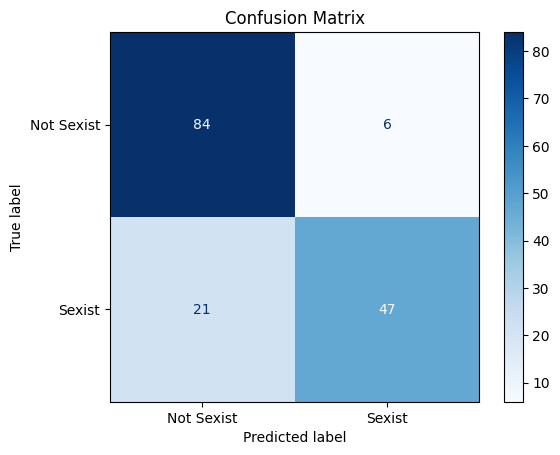

In [69]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming y_val (true labels) and final_val_predictions (predicted labels) are defined
cm = confusion_matrix(y_val, final_val_predictions)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Sexist', 'Sexist'])  # Update labels as per your dataset

# Plot the confusion matrix
disp.plot(cmap="Blues")  # Choose a colormap you prefer, e.g., "Blues"
plt.title("Confusion Matrix")
plt.show()


We see that in general it seems more difficult for the model to recognize sexist tweets, as there tends to be more mistakes in that department.

In [70]:
# Function to count `[UNK]` tokens
def count_unk_tokens(tweet, vocabulary):
    return sum(1 for token in tweet.split() if token.lower() not in vocabulary)

# Add `[UNK]` counts to the validation set
validation_df['unk_count'] = validation_df['tweet'].apply(lambda tweet: count_unk_tokens(tweet, vocabulary))
validation_df['unk_percentage'] = validation_df['unk_count'] / validation_df['tweet'].apply(lambda tweet: len(tweet.split()))

# Add model predictions
validation_df['predicted_label'] = final_val_predictions

# Group by prediction and calculate `[UNK]` statistics
unk_by_prediction = validation_df.groupby('predicted_label').agg(
    total_tweets=('tweet', 'count'),
    total_unk=('unk_count', 'sum'),
    avg_unk_per_tweet=('unk_count', 'mean'),
    avg_unk_percentage=('unk_percentage', 'mean')
)

# Map numeric labels to class names
unk_by_prediction.index = ['Not Sexist', 'Sexist']

# Print results
print("UNK Token Statistics by Model Prediction:")
print(unk_by_prediction)

UNK Token Statistics by Model Prediction:
            total_tweets  total_unk  avg_unk_per_tweet  avg_unk_percentage
Not Sexist           105        341           3.247619            0.122583
Sexist                53        152           2.867925            0.093405


This code underlines the impact of the [UNK] label in the validation set.

Furtermore, we noticed that the model would benefit from data augmentation, which cannot be done in this case as it would be too complicated and not accurate, but in general having more data, artificial or real would be good.

### Confusion matrix for the transformers


In [72]:
predictions_output = trainer.predict(tokenized_test)
predictions = np.argmax(predictions_output.predictions, axis=1)
true_labels = predictions_output.label_ids

100%|██████████| 18/18 [00:06<00:00,  2.79it/s]


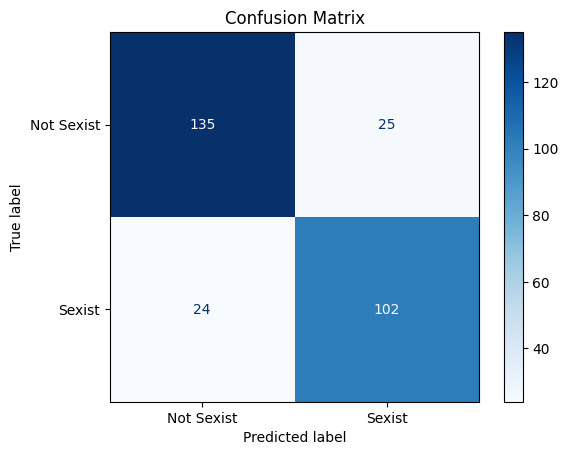

In [74]:
# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Sexist', 'Sexist'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

- Overall, the model achieves a good balance between true positives and true negatives
- False positives: 25 "Not Sexist" samples were incorrectly classified as "Sexist". The model may be slightly over-sensitive to detecting "Sexist" language, possibly due to certain keywords 
- False negatives: 24 "Sexist" samples were missed and classified as "Not Sexist". This might suggest again that the model struggles to identify subtle or implicit forms of sexist language

# [Task 8 - 0.5 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.


# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.

# FAQ

Please check this frequently asked questions before contacting us

### Execution Order

You are **free** to address tasks in any order (if multiple orderings are available).

### Trainable Embeddings

You are **free** to define a trainable or non-trainable Embedding layer to load the GloVe embeddings.

### Model architecture

You **should not** change the architecture of a model (i.e., its layers).
However, you are **free** to play with their hyper-parameters.


### Neural Libraries

You are **free** to use any library of your choice to implement the networks (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Keras TimeDistributed Dense layer

If you are using Keras, we recommend wrapping the final Dense layer with `TimeDistributed`.

### Robust Evaluation

Each model is trained with at least 3 random seeds.

Task 4 requires you to compute the average performance over the 3 seeds and its corresponding standard deviation.

### Model Selection for Analysis

To carry out the error analysis you are **free** to either

* Pick examples or perform comparisons with an individual seed run model (e.g., Baseline seed 1337)
* Perform ensembling via, for instance, majority voting to obtain a single model.

### Error Analysis

Some topics for discussion include:
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.

### Bonus Points
Bonus points are arbitrarily assigned based on significant contributions such as:
- Outstanding error analysis
- Masterclass code organization
- Suitable extensions
Note that bonus points are only assigned if all task points are attributed (i.e., 6/6).

**Possible Extensions/Explorations for Bonus Points:**
- **Try other preprocessing strategies**: e.g., but not limited to, explore techniques tailored specifically for tweets or  methods that are common in social media text.
- **Experiment with other custom architectures or models from HuggingFace**
- **Explore Spanish tweets**: e.g., but not limited to, leverage multilingual models to process Spanish tweets and assess their performance compared to monolingual models.







# The End